In [1]:
import pandas as pd

df = pd.read_csv('syb-18-chapter_22_shipping_table_22.5.csv')
df.head()

,Year,POL (Crude & Product),Fertiliser,Fertiliser Raw Material,Iron Ore,Coal,Foodgrains,Others,Total
0,2000-01,108.38,3.03,10.31,40.46,54.52,1.98,62.46,281.13
1,2001-02,103.28,3.49,10.48,45.76,51.25,3.91,69.40,287.58
2,2002-03,109.57,2.88,10.29,50.56,53.04,8.54,78.68,313.55
3,2003-04,122.16,2.86,8.94,58.85,54.90,6.84,90.25,344.80
4,2004-05,126.44,3.85,10.67,76.20,60.65,3.84,102.11,383.76


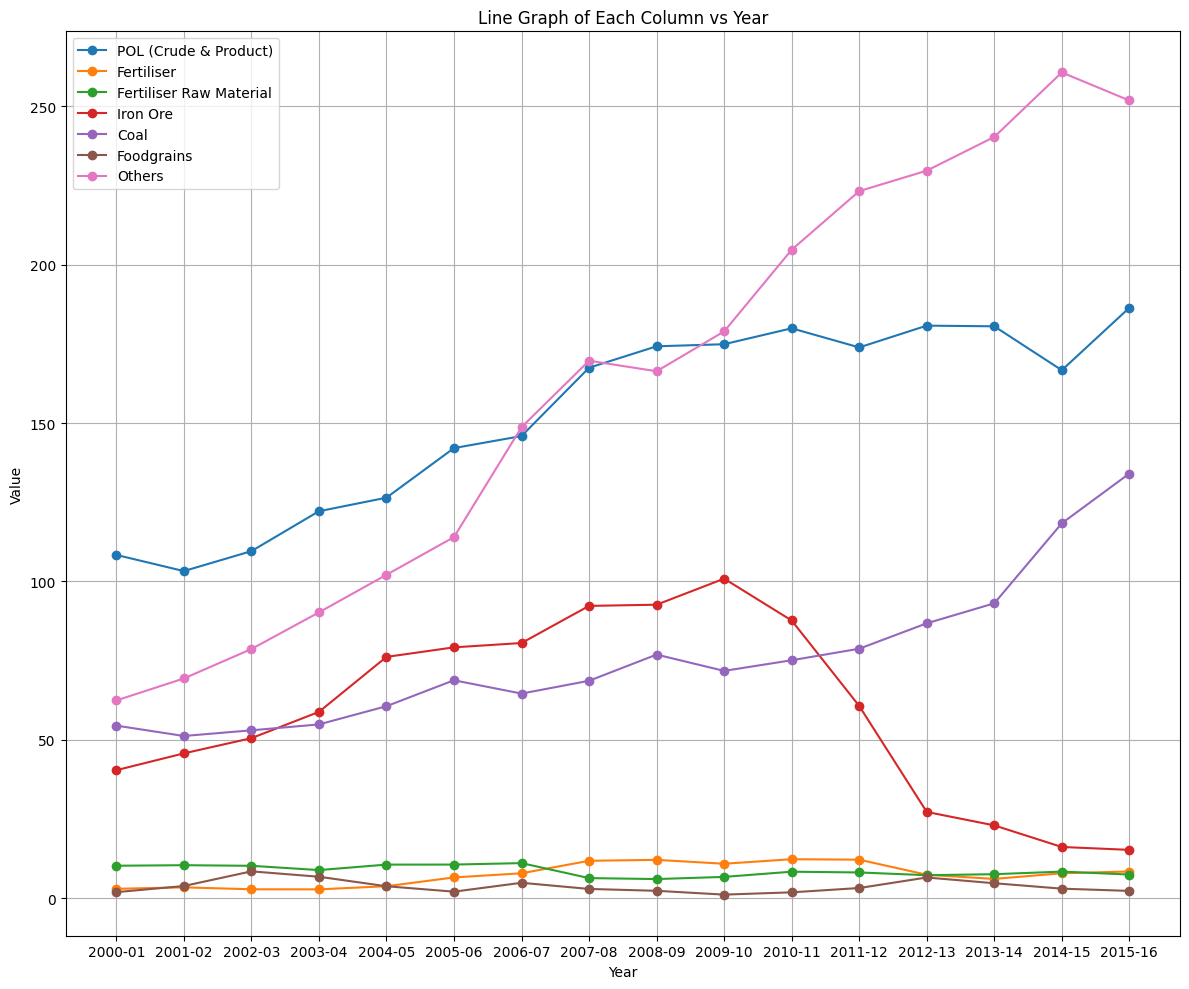

In [2]:
import matplotlib.pyplot as plt

# Ensure data_cols is defined (exclude any 'Total' column, case-insensitive)
try:
    data_cols
except NameError:
    data_cols = [col for col in df.columns[1:] if 'total' not in col.lower()]

# Ensure year_col is defined; fallback to the first column name (usually 'Year')
try:
    year_col
except NameError:
    year_col = df.columns[0]

plt.figure(figsize=(12, 10))
for col in data_cols:
    plt.plot(df[year_col], df[col], marker='o', label=col)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Line Graph of Each Column vs Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


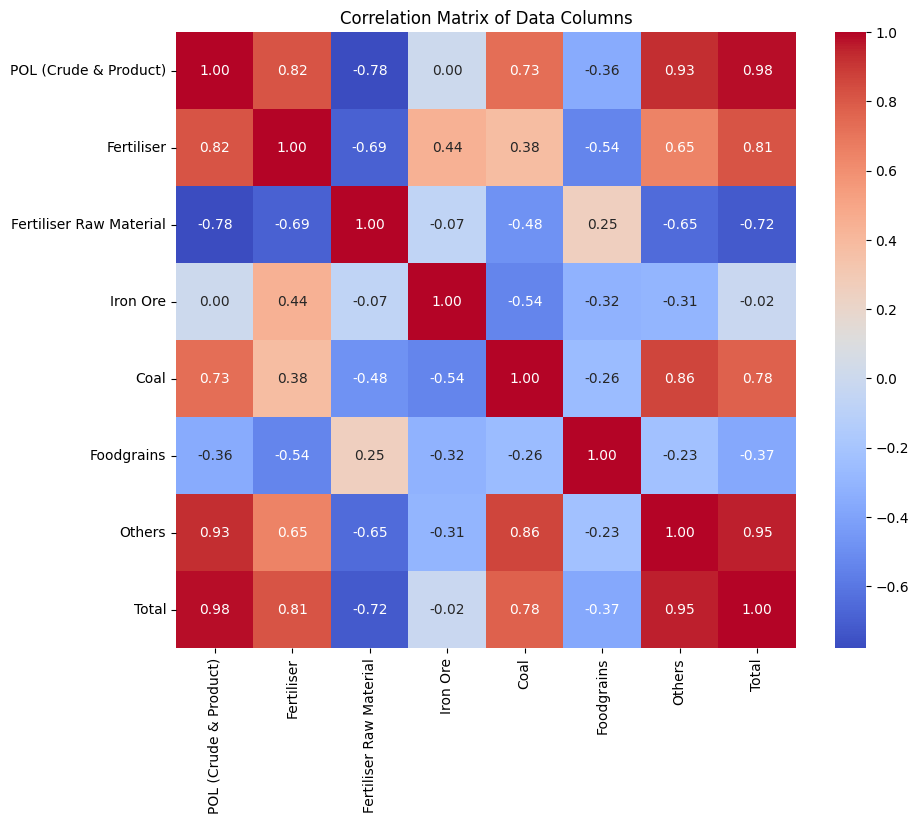

In [3]:
# Visualize the correlation matrix (excluding the year column)
import seaborn as sns

corr = df.iloc[:, 1:].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Data Columns')
plt.show()

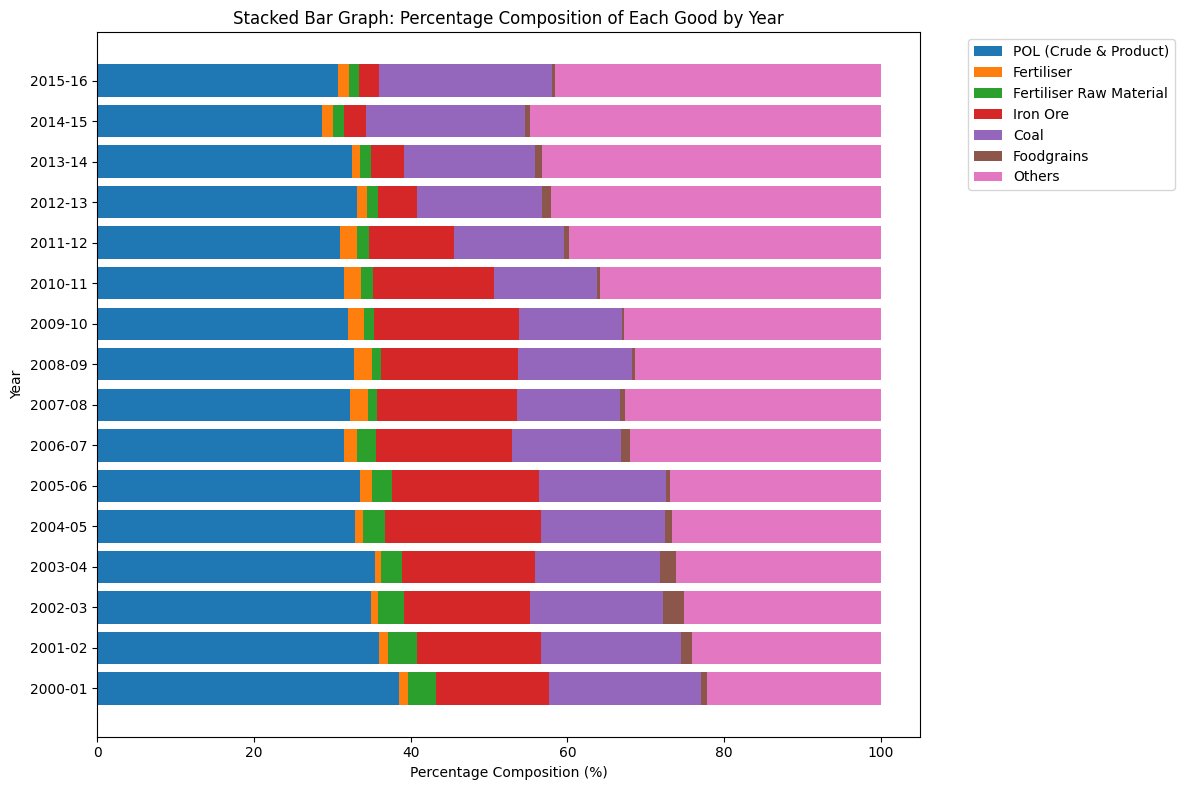

In [4]:
# Create a stacked bar graph of percentage composition for each good by year (excluding the total column)

# Exclude the 'Total' column if present (case-insensitive match)
data_cols = [col for col in df.columns[1:] if 'total' not in col.lower()]
df_percent = df.copy()
df_percent[data_cols] = df_percent[data_cols].div(df_percent[data_cols].sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 8))
bottom = None
for col in data_cols:
    plt.barh(df[year_col], df_percent[col], left=bottom, label=col)
    if bottom is None:
        bottom = df_percent[col].copy()
    else:
        bottom += df_percent[col]
plt.xlabel('Percentage Composition (%)')
plt.ylabel('Year')
plt.title('Stacked Bar Graph: Percentage Composition of Each Good by Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

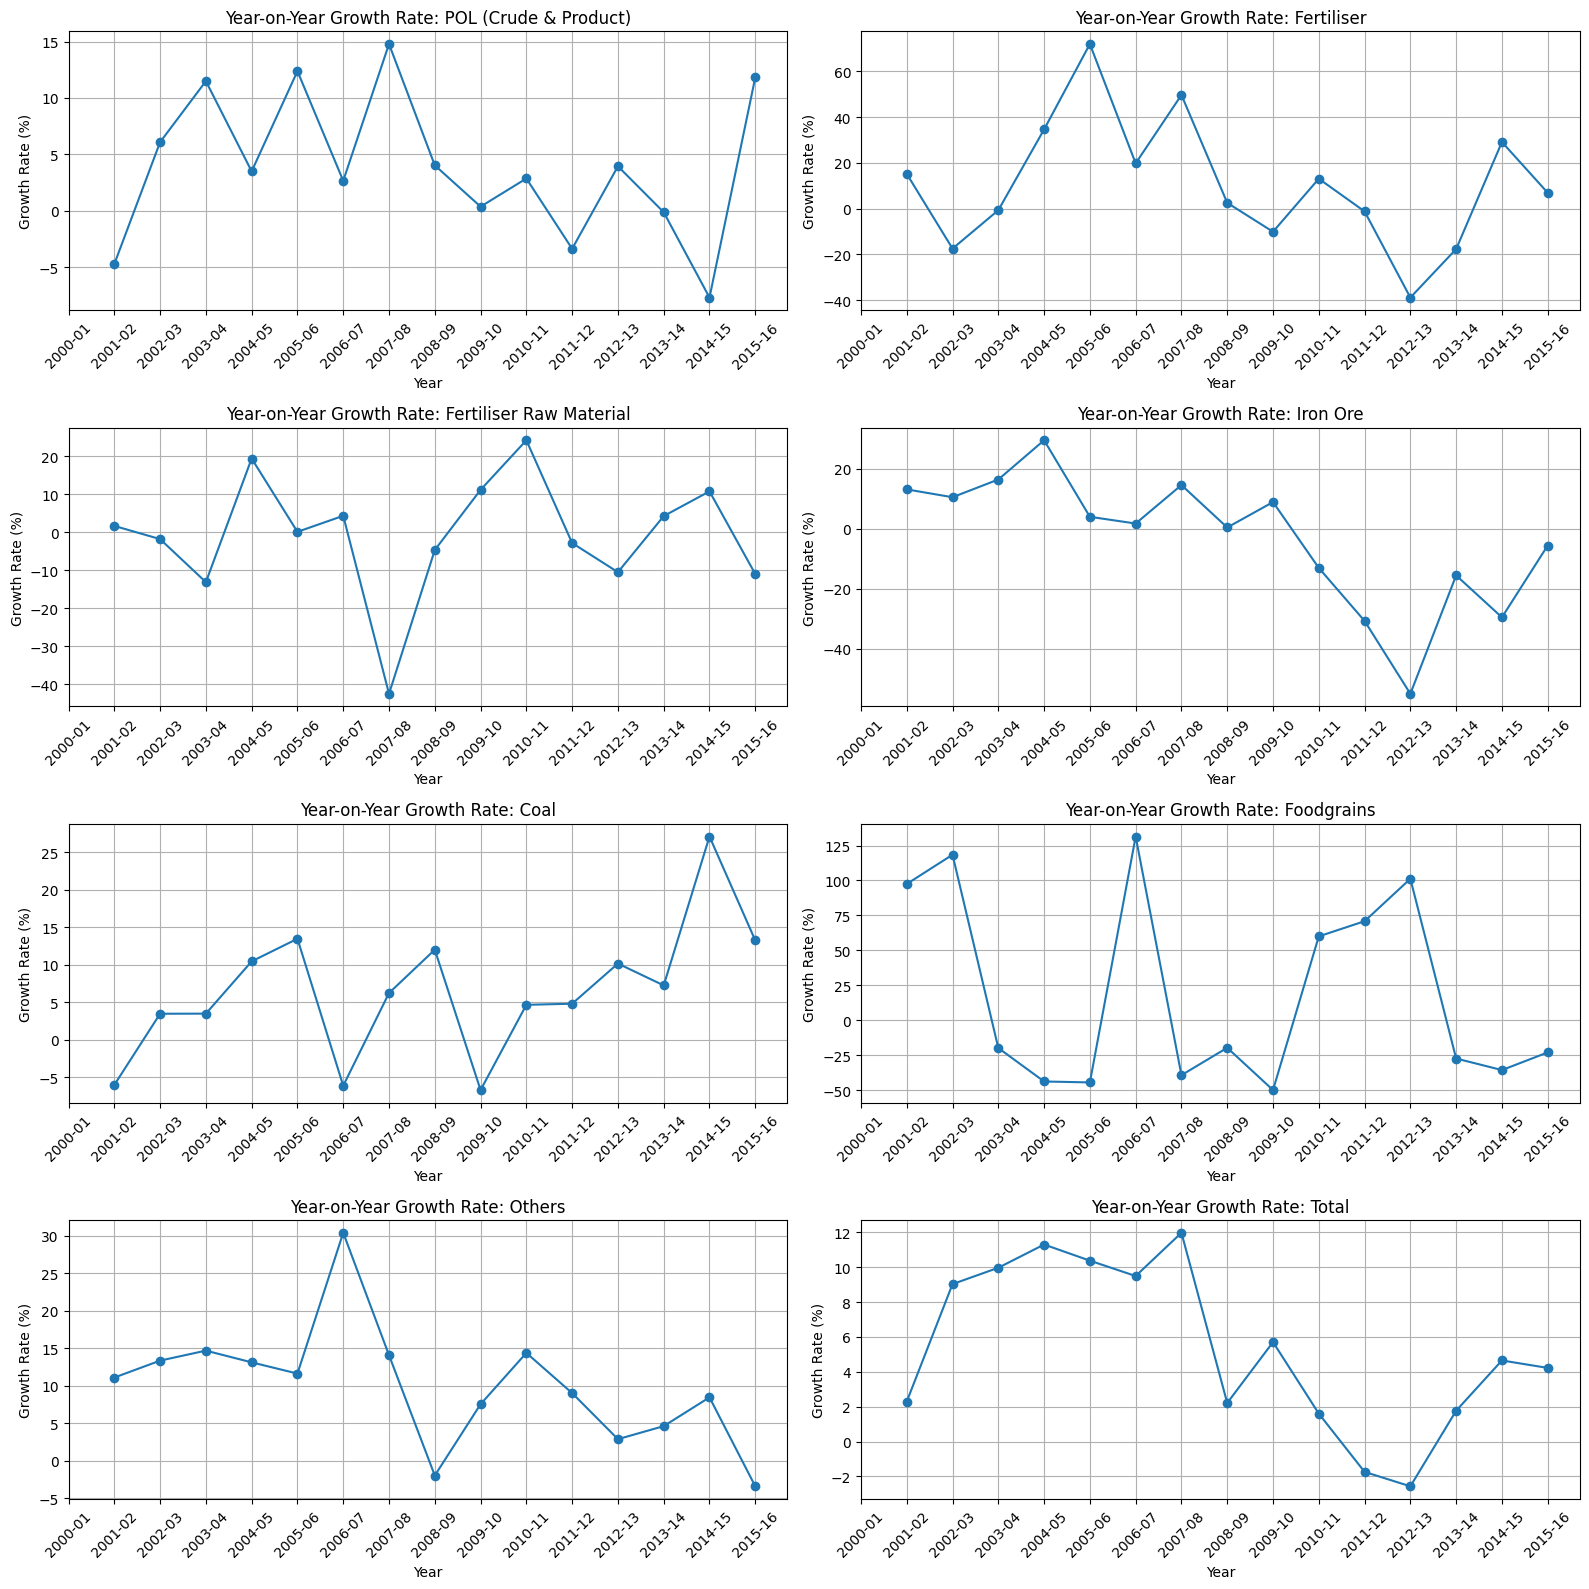

In [5]:
# Plot year-on-year growth rate for each commodity (excluding 'Total' and 'Year') with x-axis markers on all graphs

commodities = [col for col in df.columns[1:]]
years = df[year_col]

growth_rates = df[commodities].pct_change() * 100

fig, axes = plt.subplots(4, 2, figsize=(16, 16))  # Removed sharex=True
axes = axes.flatten()

for i, col in enumerate(commodities):
    axes[i].plot(years, growth_rates[col], marker='o')
    axes[i].set_title(f'Year-on-Year Growth Rate: {col}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Growth Rate (%)')
    axes[i].grid(True)
    axes[i].set_xticks(years)
    axes[i].set_xticklabels(years, rotation=45)

plt.tight_layout()
plt.show()

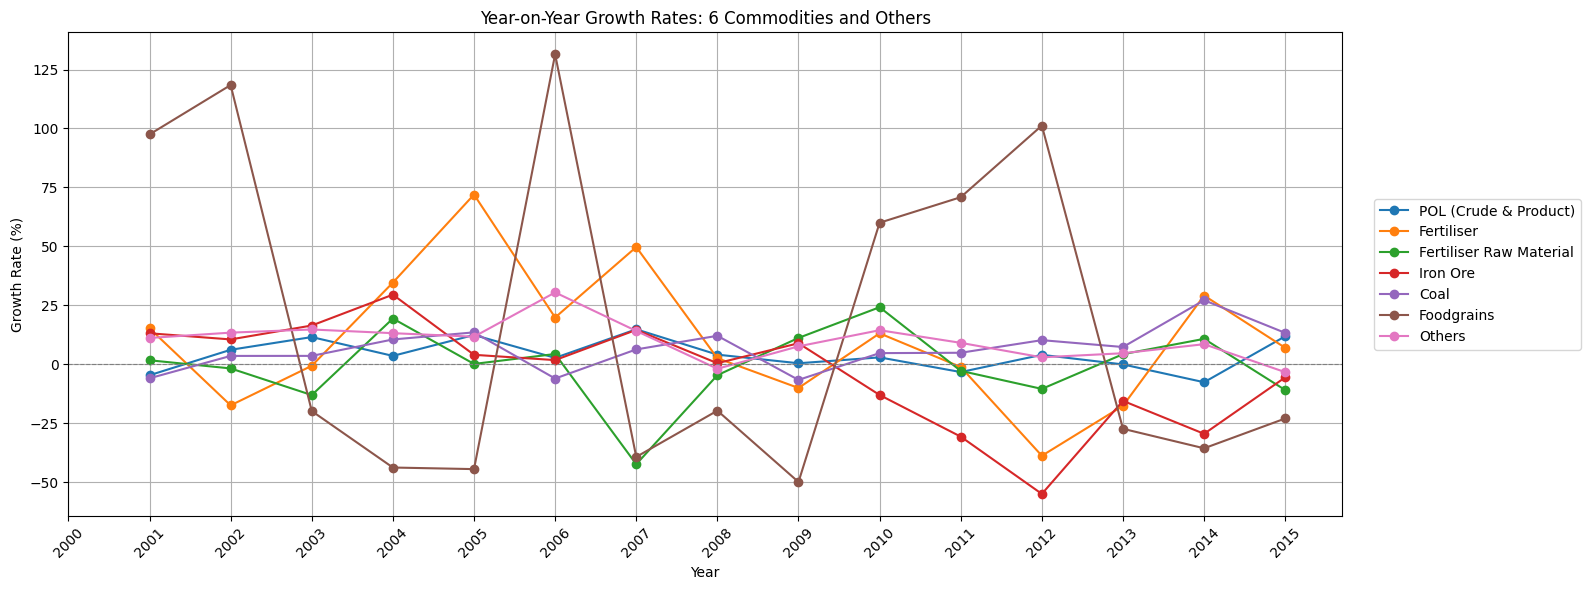

In [6]:
# Line chart visualizing year-on-year growth rates for the 6 main commodities plus "Others" on one elongated plot

# Identify data columns excluding the year and any total column
candidate_cols = [col for col in df.columns if col != year_col and 'total' not in col.lower()]

# Try to find an "Others" column (case-insensitive match)
others_col = next((c for c in candidate_cols if 'other' in c.lower()), None)

# Exclude the Others column when selecting the top 6 commodities
main_cols = [c for c in candidate_cols if c != others_col]

# Select up to 6 main commodities
selected_main = main_cols[:6]

# Build final list to plot: selected 6 + Others (if present)
final_cols = selected_main.copy()
if others_col:
    final_cols.append(others_col)
# If Others wasn't found and we have fewer than 7 cols, include additional cols to reach up to 7 (optional)
elif len(final_cols) < 7:
    extras = [c for c in main_cols if c not in selected_main]
    final_cols += extras[:max(0, 7 - len(final_cols))]

# Compute year-on-year growth rates (percentage)
growth_rates = df[final_cols].pct_change() * 100

# Extract numeric years for plotting (works with strings like "Year 2020" or "2020")
years = df[year_col].str.extract(r'(\d{4})')[0].astype(int)

# Plot on a single elongated figure
plt.figure(figsize=(16, 6))
for col in final_cols:
    plt.plot(years, growth_rates[col], marker='o', label=col)

plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.title('Year-on-Year Growth Rates: 6 Commodities and Others')
plt.xticks(years, rotation=45)
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()


Forecast for year 2016:
POL (Crude & Product): 188.0389440479723
Fertiliser: 8.630816251026678
Fertiliser Raw Material: 7.608204921177458
Iron Ore: 14.806786078780972
Coal: 143.08090991189442
Foodgrains: 2.313890184568734
Others: 246.4107217660829


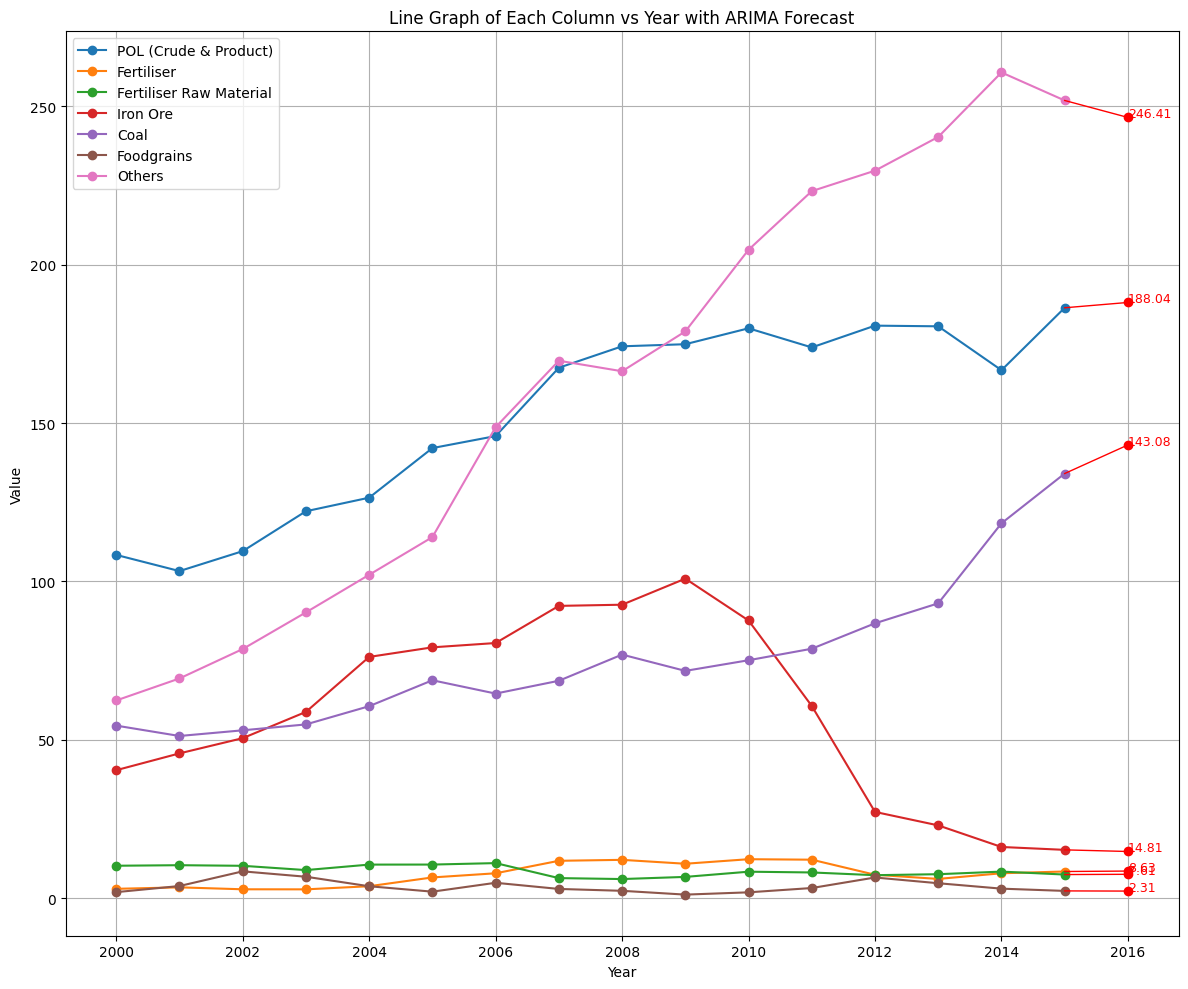

In [7]:
# Forecast next year's value for each commodity using ARIMA and plot the predictions
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

forecast_results = {}
next_year = df[year_col].str.extract(r'(\d{4})')[0].astype(int).max() + 1

for col in [c for c in df.columns[1:] if 'total' not in c.lower()]:
    series = df[col].dropna()
    try:
        model = ARIMA(series, order=(1,1,0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1).iloc[0]
        forecast_results[col] = forecast
    except Exception as e:
        forecast_results[col] = f'Error: {e}'

print(f"\nForecast for year {next_year}:")
for col, value in forecast_results.items():
    print(f"{col}: {value}")

# Plot actual and predicted values for each commodity
years = df[year_col].str.extract(r'(\d{4})')[0].astype(int)
plt.figure(figsize=(12, 10))
for col in [c for c in df.columns[1:] if 'total' not in c.lower()]:
    plt.plot(years, df[col], marker='o', label=col)
    # Plot the prediction as a red dot
    if not isinstance(forecast_results[col], str):
        plt.plot(next_year, forecast_results[col], marker='o', color='red')
        plt.text(next_year, forecast_results[col], f'{forecast_results[col]:.2f}', color='red', fontsize=9)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Line Graph of Each Column vs Year with ARIMA Forecast')
# connect forecast to last actual point with a red line, then show legend
for col in [c for c in df.columns[1:] if 'total' not in c.lower()]:
    f = forecast_results.get(col)
    if not isinstance(f, str) and pd.notnull(f):
        last_year = years.iloc[-1]
        last_val = df[col].iloc[-1]
        plt.plot([last_year, next_year], [last_val, f], color='red', linestyle='-', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

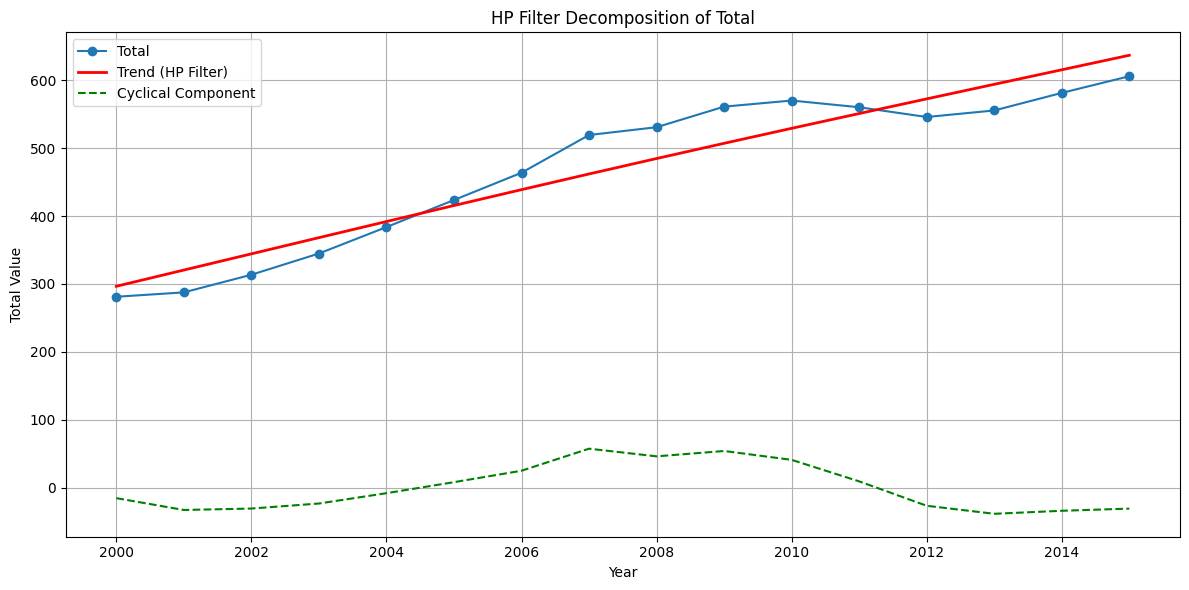

In [8]:
# Hodrick-Prescott (HP) filter on the Total column and plot the result
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt

# Extract the year as integer
years = df[year_col].str.extract(r'(\d{4})')[0].astype(int)
# Find the total column (case-insensitive)
total_col = [col for col in df.columns if 'total' in col.lower()]
if total_col:
    total_series = df[total_col[0]].dropna()
    cycle, trend = hpfilter(total_series, lamb=1600)
    plt.figure(figsize=(12, 6))
    plt.plot(years, total_series, label='Total', marker='o')
    plt.plot(years, trend, label='Trend (HP Filter)', color='red', linewidth=2)
    plt.plot(years, cycle, label='Cyclical Component', color='green', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Total Value')
    plt.title('HP Filter Decomposition of Total')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print('No Total column found in the data.')

C:\Users\soman\AppData\Local\Temp\ipykernel_33248\164692071.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(commodity, (volatility[i], avg_growth[i]),


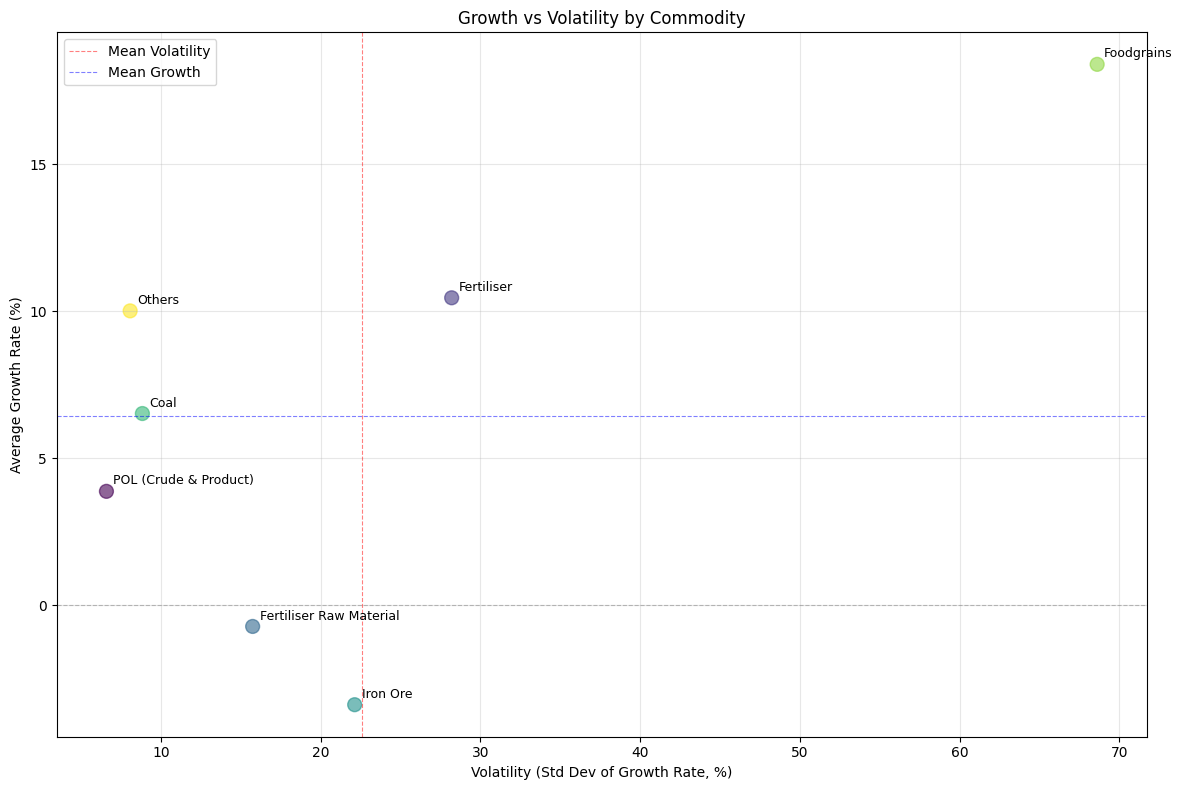


Growth and Volatility Summary:
--------------------------------------------------
POL (Crude & Product)          | Growth:   3.87% | Volatility:   6.59%
Fertiliser                     | Growth:  10.45% | Volatility:  28.20%
Fertiliser Raw Material        | Growth:  -0.72% | Volatility:  15.74%
Iron Ore                       | Growth:  -3.38% | Volatility:  22.13%
Coal                           | Growth:   6.52% | Volatility:   8.84%
Foodgrains                     | Growth:  18.39% | Volatility:  68.60%
Others                         | Growth:  10.01% | Volatility:   8.07%


In [9]:
# Scatter plot: Growth vs Volatility by commodity
import numpy as np

# Get commodities (excluding year and total columns)
commodities = [col for col in df.columns[1:] if 'total' not in col.lower()]

# Calculate average growth rate and volatility (standard deviation of growth rates) for each commodity
growth_rates = df[commodities].pct_change() * 100
avg_growth = growth_rates.mean()
volatility = growth_rates.std()

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(volatility, avg_growth, s=100, alpha=0.6, c=range(len(commodities)), cmap='viridis')

# Add labels for each point
for i, commodity in enumerate(commodities):
    plt.annotate(commodity, (volatility[i], avg_growth[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
plt.axvline(volatility.mean(), color='red', linewidth=0.8, linestyle='--', alpha=0.5, label='Mean Volatility')
plt.axhline(avg_growth.mean(), color='blue', linewidth=0.8, linestyle='--', alpha=0.5, label='Mean Growth')

plt.xlabel('Volatility (Std Dev of Growth Rate, %)')
plt.ylabel('Average Growth Rate (%)')
plt.title('Growth vs Volatility by Commodity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nGrowth and Volatility Summary:")
print("-" * 50)
for commodity in commodities:
    print(f"{commodity:30s} | Growth: {avg_growth[commodity]:6.2f}% | Volatility: {volatility[commodity]:6.2f}%")

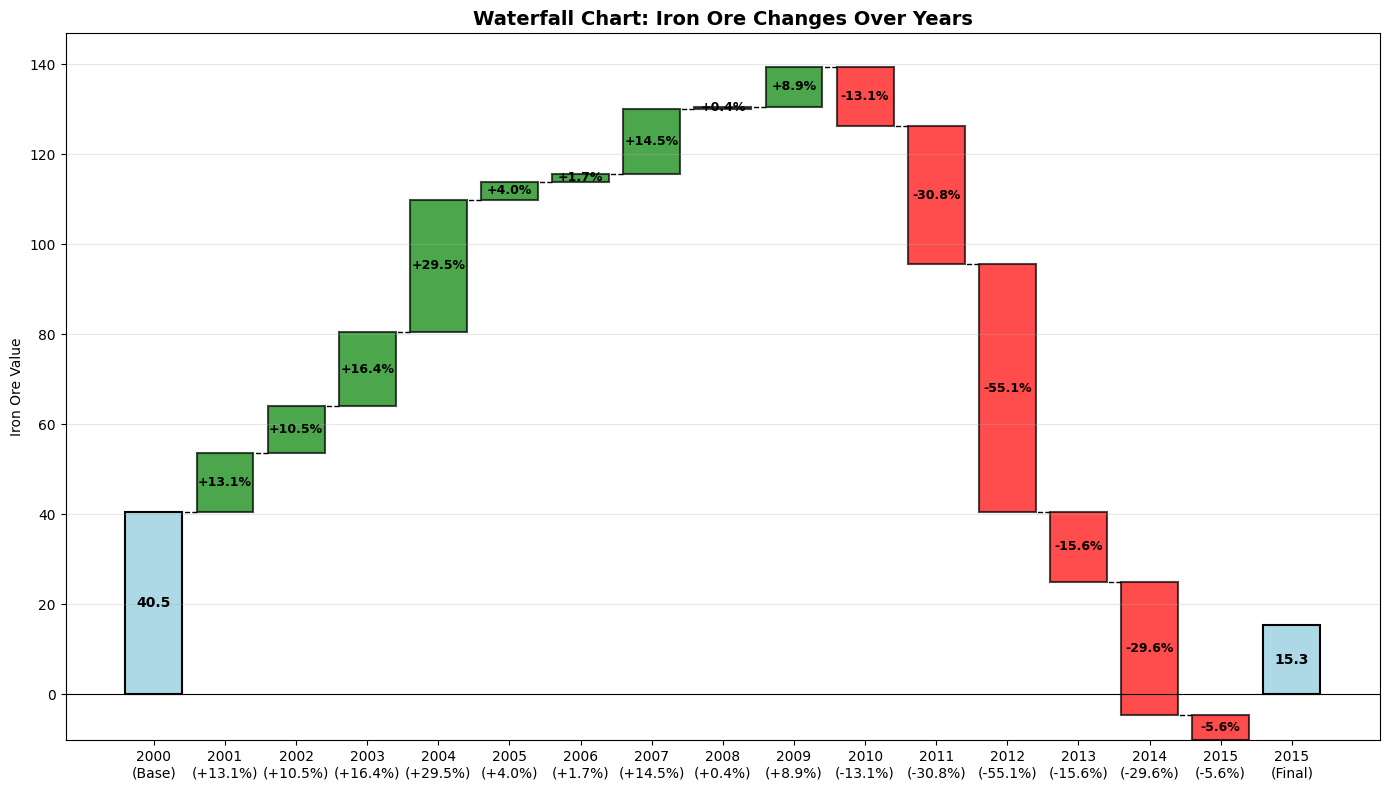


Iron Ore Analysis:
Starting value (2000): 40.46
Ending value (2015): 15.32
Total change: -25.14
Total percentage change: -62.14%


In [10]:
# Waterfall chart: Percentage change in Iron Ore over the years
import matplotlib.pyplot as plt
import numpy as np

# Extract Iron Ore data
iron_ore_col = [col for col in df.columns if 'iron ore' in col.lower()][0]
iron_ore_data = df[iron_ore_col].values
years = df[year_col].str.extract(r'(\d{4})')[0].astype(int).values

# Calculate percentage changes
pct_changes = np.diff(iron_ore_data) / iron_ore_data[:-1] * 100

# Prepare data for waterfall chart
# Start with the first year's value
values = [iron_ore_data[0]]
labels = [f'{years[0]}\n(Base)']

# Add percentage changes for each subsequent year
for i, change in enumerate(pct_changes):
    values.append(change)
    labels.append(f'{years[i+1]}\n({change:+.1f}%)')

# Add the final cumulative value
values.append(iron_ore_data[-1])
labels.append(f'{years[-1]}\n(Final)')

# Create waterfall chart
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate cumulative positions
cumulative = [values[0]]
for i in range(1, len(values) - 1):
    cumulative.append(cumulative[-1] + values[i])

# Plot bars
colors = []
bottoms = []

# First bar (base)
ax.bar(0, values[0], color='lightblue', edgecolor='black', linewidth=1.5)
colors.append('lightblue')
bottoms.append(0)

# Middle bars (changes)
for i in range(1, len(values) - 1):
    if values[i] >= 0:
        color = 'green'
        bottom = cumulative[i-1]
    else:
        color = 'red'
        bottom = cumulative[i-1] + values[i]
    
    ax.bar(i, abs(values[i]), bottom=bottom, color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Draw connecting line
    if i > 0:
        ax.plot([i-0.4, i-0.6], [cumulative[i-1], cumulative[i-1]], 'k--', linewidth=1)

# Last bar (final total)
ax.bar(len(values)-1, values[-1], color='lightblue', edgecolor='black', linewidth=1.5)

# Draw final connecting line
ax.plot([len(values)-2-0.4, len(values)-1-0.6], [cumulative[-1], cumulative[-1]], 'k--', linewidth=1)

# Customize chart
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_ylabel('Iron Ore Value')
ax.set_title('Waterfall Chart: Iron Ore Changes Over Years', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linewidth=0.8)

# Add value labels on bars
for i, val in enumerate(values):
    if i == 0 or i == len(values) - 1:
        ax.text(i, val/2, f'{val:.1f}', ha='center', va='center', fontweight='bold')
    else:
        height = cumulative[i-1] + (values[i]/2 if values[i] >= 0 else values[i]/2)
        ax.text(i, height, f'{values[i]:+.1f}%', ha='center', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nIron Ore Analysis:")
print(f"Starting value ({years[0]}): {iron_ore_data[0]:.2f}")
print(f"Ending value ({years[-1]}): {iron_ore_data[-1]:.2f}")
print(f"Total change: {iron_ore_data[-1] - iron_ore_data[0]:.2f}")
print(f"Total percentage change: {(iron_ore_data[-1] - iron_ore_data[0]) / iron_ore_data[0] * 100:+.2f}%")